# Multi-layer Perceptron

This notebook is an example of a multi-layer perceptron with Keras (https://keras.io/)

In [1]:
# Import some needed packages
import random
random.seed(2019)
import matplotlib.pyplot as plt
%matplotlib notebook
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd

Using TensorFlow backend.


## Load data

We are going to load the tweets from SemEval 2017...

In [2]:
import pandas as pd
import glob

fpattern = '../Exercise_2-TwitterSentimentAnalysis/data/twitter-20*train-*.tsv'
filenames = [filename for filename in sorted(glob.glob(fpattern))]
print(filenames)


['../Exercise_2-TwitterSentimentAnalysis/data/twitter-2013train-A.tsv', '../Exercise_2-TwitterSentimentAnalysis/data/twitter-2015train-A.tsv', '../Exercise_2-TwitterSentimentAnalysis/data/twitter-2016train-A.tsv']


In [3]:
# Load all files into a big data frame...
column_names = ['id', 'tag', 'tweet']
df = pd.concat([pd.read_csv(f, sep="\t", quoting=3, names=column_names) for f in filenames], ignore_index=True, sort=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16173 entries, 0 to 16172
Data columns (total 3 columns):
id       16173 non-null int64
tag      16173 non-null object
tweet    16173 non-null object
dtypes: int64(1), object(2)
memory usage: 379.1+ KB


,id,tag,tweet
0,264183816548130816,positive,Gas by my house hit $3.39!!!! I'm going to Cha...
1,263405084770172928,negative,Not Available
2,262163168678248449,negative,Not Available
3,264249301910310912,negative,Iranian general says Israel's Iron Dome can't ...
4,262682041215234048,neutral,Not Available


In [4]:
# Drop rows having 'Not Available'...
df = df[df.tweet != 'Not Available']
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12016 entries, 0 to 16172
Data columns (total 3 columns):
id       12016 non-null int64
tag      12016 non-null object
tweet    12016 non-null object
dtypes: int64(1), object(2)
memory usage: 375.5+ KB


,id,tag,tweet
0,264183816548130816,positive,Gas by my house hit $3.39!!!! I'm going to Cha...
3,264249301910310912,negative,Iranian general says Israel's Iron Dome can't ...
6,264105751826538497,positive,with J Davlar 11th. Main rivals are team Polan...
7,264094586689953794,negative,"Talking about ACT's &amp;&amp; SAT's, deciding..."
9,254941790757601280,negative,"They may have a SuperBowl in Dallas, but Dalla..."


## A function to convert a tweet into a set of words

In [5]:
import string
import re
#import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

# turn a document into a list of clean tokens
def clean_doc(doc):
    # Remove links...
    doc = re.sub("\w+:\/\/\S+", " ", doc)
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w.lower() in stop_words and not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

for tweet in df.tweet.head(10):
    print(tweet)
    print(clean_doc(tweet))

Gas by my house hit $3.39!!!! I'm going to Chapel Hill on Sat. :)
['Gas', 'house', 'hit', 'Im', 'going', 'Chapel', 'Hill', 'Sat']
Iranian general says Israel's Iron Dome can't deal with their missiles (keep talking like that and we may end up finding out)
['Iranian', 'general', 'says', 'Israels', 'Iron', 'Dome', 'cant', 'deal', 'missiles', 'keep', 'talking', 'like', 'may', 'end', 'finding']
with J Davlar 11th. Main rivals are team Poland. Hopefully we an make it a successful end to a tough week of training tomorrow.
['Davlar', 'Main', 'rivals', 'team', 'Poland', 'Hopefully', 'make', 'successful', 'end', 'tough', 'week', 'training', 'tomorrow']
Talking about ACT's &amp;&amp; SAT's, deciding where I want to go to college, applying to colleges and everything about college stresses me out.
['Talking', 'ACTs', 'ampamp', 'SATs', 'deciding', 'want', 'go', 'college', 'applying', 'colleges', 'everything', 'college', 'stresses']
They may have a SuperBowl in Dallas, but Dallas ain't winning a Sup

## Process all tweets, and save results in the dataframe...

In [6]:
import numpy as np

df['tokens'] = np.array([ clean_doc(tweet) for tweet in df.tweet ])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12016 entries, 0 to 16172
Data columns (total 4 columns):
id        12016 non-null int64
tag       12016 non-null object
tweet     12016 non-null object
tokens    12016 non-null object
dtypes: int64(1), object(3)
memory usage: 469.4+ KB


,id,tag,tweet,tokens
0,264183816548130816,positive,Gas by my house hit $3.39!!!! I'm going to Cha...,"[Gas, house, hit, Im, going, Chapel, Hill, Sat]"
3,264249301910310912,negative,Iranian general says Israel's Iron Dome can't ...,"[Iranian, general, says, Israels, Iron, Dome, ..."
6,264105751826538497,positive,with J Davlar 11th. Main rivals are team Polan...,"[Davlar, Main, rivals, team, Poland, Hopefully..."
7,264094586689953794,negative,"Talking about ACT's &amp;&amp; SAT's, deciding...","[Talking, ACTs, ampamp, SATs, deciding, want, ..."
9,254941790757601280,negative,"They may have a SuperBowl in Dallas, but Dalla...","[may, SuperBowl, Dallas, Dallas, aint, winning..."


## Perform all actions also for dev/test data...

In [7]:
fpattern = '../Exercise_2-TwitterSentimentAnalysis/data/twitter-20*dev-*.tsv'
devfs    = [filename for filename in sorted(glob.glob(fpattern))]
fpattern = '../Exercise_2-TwitterSentimentAnalysis/data/twitter-20*test-*.tsv'
testfs   = [filename for filename in sorted(glob.glob(fpattern))]
df_dev   = pd.concat([pd.read_csv(f, sep="\t", quoting=3, names=column_names) for f in devfs],  ignore_index=True, sort=True)
df_test  = pd.concat([pd.read_csv(f, sep="\t", quoting=3, names=column_names) for f in testfs], ignore_index=True, sort=True)
df_dev   = df_dev[df_dev.tweet != 'Not Available']
df_test  = df_test[df_test.tweet != 'Not Available']
df_dev['tokens']  = np.array([ clean_doc(tweet) for tweet in df_dev.tweet ])
df_test['tokens'] = np.array([ clean_doc(tweet) for tweet in df_test.tweet ])

## Extract our vocabulary...

In [8]:
from collections import Counter
import itertools

vocabulary = Counter()
for tweet_tokens in itertools.chain(df.tokens, df_dev.tokens, df_test.tokens):
    vocabulary.update(tweet_tokens)

print('Total tweets: ', sum(1 for _ in itertools.chain(df.tokens, df_dev.tokens, df_test.tokens)))
vocabulary.most_common(10)

Total tweets:  30790


[('may', 4040),
 ('tomorrow', 3942),
 ('Im', 1754),
 ('going', 1704),
 ('amp', 1687),
 ('see', 1667),
 ('day', 1667),
 ('Friday', 1648),
 ('like', 1582),
 ('Sunday', 1577)]

## Filter words using the vocabulary...

In [9]:
def token_to_vector_words(tokens, vocabulary):
    tokens = [w for w in tokens if w in vocabulary]
    return ' '.join(tokens)

print(df.tweet[0])
token_to_vector_words(df.tokens[0], vocabulary)

Gas by my house hit $3.39!!!! I'm going to Chapel Hill on Sat. :)


'Gas house hit Im going Chapel Hill Sat'

In [10]:
df['vector_tokens']      = np.array([ token_to_vector_words(tweet, vocabulary) for tweet in df.tokens ])
df_dev['vector_tokens']  = np.array([ token_to_vector_words(tweet, vocabulary) for tweet in df_dev.tokens ])
df_test['vector_tokens'] = np.array([ token_to_vector_words(tweet, vocabulary) for tweet in df_test.tokens ])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12016 entries, 0 to 16172
Data columns (total 5 columns):
id               12016 non-null int64
tag              12016 non-null object
tweet            12016 non-null object
tokens           12016 non-null object
vector_tokens    12016 non-null object
dtypes: int64(1), object(4)
memory usage: 883.2+ KB


,id,tag,tweet,tokens,vector_tokens
0,264183816548130816,positive,Gas by my house hit $3.39!!!! I'm going to Cha...,"[Gas, house, hit, Im, going, Chapel, Hill, Sat]",Gas house hit Im going Chapel Hill Sat
3,264249301910310912,negative,Iranian general says Israel's Iron Dome can't ...,"[Iranian, general, says, Israels, Iron, Dome, ...",Iranian general says Israels Iron Dome cant de...
6,264105751826538497,positive,with J Davlar 11th. Main rivals are team Polan...,"[Davlar, Main, rivals, team, Poland, Hopefully...",Davlar Main rivals team Poland Hopefully make ...
7,264094586689953794,negative,"Talking about ACT's &amp;&amp; SAT's, deciding...","[Talking, ACTs, ampamp, SATs, deciding, want, ...",Talking ACTs ampamp SATs deciding want go coll...
9,254941790757601280,negative,"They may have a SuperBowl in Dallas, but Dalla...","[may, SuperBowl, Dallas, Dallas, aint, winning...",may SuperBowl Dallas Dallas aint winning Super...


In [11]:
# Map tag from class (positive, negative) to numbers...
df['btag']      = df.tag.astype('category').cat.codes
df_dev['btag']  = df_dev.tag.astype('category').cat.codes
df_test['btag'] = df_test.tag.astype('category').cat.codes
df_dev.head(6)

,id,tag,tweet,tokens,vector_tokens,btag
0,638060586258038784,neutral,05 Beat it - Michael Jackson - Thriller (25th ...,"[Beat, Michael, Jackson, Thriller, Anniversary...",Beat Michael Jackson Thriller Anniversary Edit...,1
1,638061181823922176,positive,Jay Z joins Instagram with nostalgic tribute t...,"[Jay, joins, Instagram, nostalgic, tribute, Mi...",Jay joins Instagram nostalgic tribute Michael ...,2
2,638083821364244480,neutral,Michael Jackson: Bad 25th Anniversary Edition ...,"[Michael, Jackson, Bad, Anniversary, Edition, ...",Michael Jackson Bad Anniversary Edition Pictur...,1
4,638125563790557184,positive,18th anniv of Princess Diana's death. I still ...,"[anniv, Princess, Dianas, death, still, want, ...",anniv Princess Dianas death still want believe...,2
5,638130776727535617,positive,@oridaganjazz The 1st time I heard Michael Jac...,"[oridaganjazz, time, heard, Michael, Jackson, ...",oridaganjazz time heard Michael Jackson sing H...,2
8,638162155250954241,negative,@etbowser do u enjoy his 2nd rate Michael Jack...,"[etbowser, enjoy, rate, Michael, Jackson, bit,...",etbowser enjoy rate Michael Jackson bit Honest...,0


## Lets make our vectors...

In [12]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.vector_tokens)
#print(tokenizer.word_counts)
#print(tokenizer.document_count)
#print(tokenizer.word_index)
#print(tokenizer.word_docs)
mode = 'freq' ;# one of "binary", "count", "tfidf", "freq"
Xtrain = tokenizer.texts_to_matrix(df.vector_tokens, mode=mode)
Ytrain = df.btag
Xtest  = tokenizer.texts_to_matrix(df_test.vector_tokens, mode=mode)
Ytest  = df_test.btag
print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)
#print(Ytrain[0])
#print(*Xtrain[0], sep = "\n")
from keras.utils import to_categorical
Ytrain_one_hot = to_categorical(Ytrain)
Ytest_one_hot  = to_categorical(Ytest)
print("======================")
print(Ytrain_one_hot.shape)
print(Ytrain_one_hot)
print("======================")
print(Ytest_one_hot.shape)
print(Ytest_one_hot)

(12016, 23621) (17213, 23621) (12016,) (17213,)
(12016, 3)
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
(17213, 3)
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


## A simple MLP model...

In [13]:
n_words = Xtest.shape[1]
print(n_words)

23621


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1511808   
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 1,512,003
Trainable params: 1,512,003
Non-trainable params: 0
_________________________________________________________________


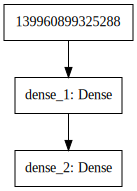

In [14]:
from keras.utils.vis_utils import plot_model

# define network
model = Sequential()
model.add(Dense(units=64, activation='relu', input_shape=(n_words,)))
model.add(Dense(units=3, activation='softmax'))
# compile network
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])
# summarize defined model
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Fit our network...

In [15]:
# fit network
from keras import backend as K
model.fit(K.cast_to_floatx(Xtrain), K.cast_to_floatx(Ytrain_one_hot), batch_size=128, epochs=120, verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/120
 - 1s - loss: 0.2201 - acc: 0.4340
Epoch 2/120
 - 0s - loss: 0.2161 - acc: 0.4292
Epoch 3/120
 - 0s - loss: 0.2132 - acc: 0.4308
Epoch 4/120
 - 0s - loss: 0.2111 - acc: 0.4312
Epoch 5/120
 - 0s - loss: 0.2095 - acc: 0.4312
Epoch 6/120
 - 0s - loss: 0.2083 - acc: 0.4313
Epoch 7/120
 - 0s - loss: 0.2074 - acc: 0.4312
Epoch 8/120
 - 0s - loss: 0.2067 - acc: 0.4312
Epoch 9/120
 - 0s - loss: 0.2061 - acc: 0.4313
Epoch 10/120
 - 0s - loss: 0.2057 - acc: 0.4312
Epoch 11/120
 - 0s - loss: 0.2053 - acc: 0.4313
Epoch 12/120
 - 0s - loss: 0.2050 - acc: 0.4309
Epoch 13/120
 - 0s - loss: 0.2047 - acc: 0.4313
Epoch 14/120
 - 0s - loss: 0.2045 - acc: 0.4310
Epoch 15/120
 - 0s - loss: 0.2044 - acc: 0.4312
Epoch 16/120
 - 0s - loss: 0.2042 - acc: 0.4312
Epoch 17/120
 - 0s - loss: 0.2041 - acc: 0.4316
Epoch 18/120
 - 0s - loss: 0.2040 - acc: 0.4310
Epoch 19/120
 - 0s - loss: 0.2039 - acc: 0.4340
Epoch 20/120
 - 0s - loss: 0.2038 - acc: 0.4325
E

## Evaluate our fit network...


In [16]:
# evaluate
loss, acc = model.evaluate(K.cast_to_floatx(Xtest), K.cast_to_floatx(Ytest_one_hot), verbose=2)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 54.621507


In [17]:
Y_hat = model.predict(K.cast_to_floatx(Xtest))
Y_hat_int = np.argmax(Y_hat, axis=1)
Y_int = np.argmax(Ytest_one_hot, axis=1)
print(Y_hat, Ytest_one_hot)
print(Y_hat_int, Y_int)

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

d = dict(enumerate(df_test.tag.astype('category').cat.categories))
print(d, list(d.values()))
target_names = list(d.values())
print(confusion_matrix(Y_int, Y_hat_int))
print(classification_report(Y_int, Y_hat_int, digits=4, target_names=target_names))
print(accuracy_score(Y_int, Y_hat_int))

[[0.13850139 0.4322933  0.42920536]
 [0.13853018 0.43273112 0.42873874]
 [0.13872077 0.43337515 0.42790407]
 ...
 [0.13961847 0.4325549  0.4278266 ]
 [0.13915813 0.42796198 0.4328799 ]
 [0.14030686 0.43082747 0.42886564]] [[0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]
[1 1 1 ... 1 2 1] [1 1 2 ... 1 0 1]
{0: 'negative', 1: 'neutral', 2: 'positive'} ['negative', 'neutral', 'positive']
[[   0 2102  454]
 [   0 6665 1713]
 [   0 3542 2737]]
              precision    recall  f1-score   support

    negative     0.0000    0.0000    0.0000      2556
     neutral     0.5415    0.7955    0.6444      8378
    positive     0.5581    0.4359    0.4895      6279

   micro avg     0.5462    0.5462    0.5462     17213
   macro avg     0.3665    0.4105    0.3780     17213
weighted avg     0.4671    0.5462    0.4922     17213

0.5462150700052286


/home/petasis/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Comparing Word Scoring Methods

In [18]:
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras import backend as K

def prepare_data(train_df, test_df, mode):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_df.vector_tokens)
    Xtrain = tokenizer.texts_to_matrix(train_df.vector_tokens, mode=mode)
    Ytrain = to_categorical(train_df.btag)
    Xtest  = tokenizer.texts_to_matrix(test_df.vector_tokens, mode=mode)
    Ytest  = to_categorical(test_df.btag)
    return K.cast_to_floatx(Xtrain), K.cast_to_floatx(Ytrain), K.cast_to_floatx(Xtest), K.cast_to_floatx(Ytest)


In [19]:
# evaluate a neural network model
def evaluate_mode(Xtrain, Ytrain, Xtest, Ytest, mode):
    scores = list()
    n_repeats = 6
    n_words = Xtest.shape[1]
    for i in range(n_repeats):
        # define network
        model = Sequential()
        model.add(Dense(units=64, input_shape=(n_words,), activation='relu'))
        model.add(Dense(units=3, activation='softmax'))
        # compile network
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        # fit network
        model.fit(Xtrain, Ytrain, batch_size=128, epochs=20, verbose=2)
        # evaluate
        loss, acc = model.evaluate(Xtest, Ytest, verbose=0)
        scores.append(acc)
        print('%s %d accuracy: %s' % (mode, (i+1), acc))
        Y_int = np.argmax(Ytest, axis=1)
        Y_hat = model.predict(Xtest)
        Y_hat_int = np.argmax(Y_hat, axis=1)
        print(confusion_matrix(Y_int, Y_hat_int))
        print(classification_report(Y_int, Y_hat_int, digits=4, target_names=target_names))
        print(accuracy_score(Y_int, Y_hat_int))
    return scores

In [20]:
# run experiment
modes = ['binary', 'count', 'tfidf', 'freq']
results = pd.DataFrame()
for mode in modes:
    # prepare data for mode
    Xtrain, Ytrain, Xtest, Ytest = prepare_data(df, df_test, mode)
    # evaluate model on data for mode
    results[mode] = evaluate_mode(Xtrain, Ytrain, Xtest, Ytest, mode)



Epoch 1/20
 - 1s - loss: 0.9281 - acc: 0.5686
Epoch 2/20
 - 0s - loss: 0.6104 - acc: 0.7587
Epoch 3/20
 - 1s - loss: 0.3709 - acc: 0.8830
Epoch 4/20
 - 1s - loss: 0.2273 - acc: 0.9383
Epoch 5/20
 - 1s - loss: 0.1460 - acc: 0.9660
Epoch 6/20
 - 1s - loss: 0.1001 - acc: 0.9809
Epoch 7/20
 - 1s - loss: 0.0725 - acc: 0.9862
Epoch 8/20
 - 1s - loss: 0.0548 - acc: 0.9909
Epoch 9/20
 - 1s - loss: 0.0429 - acc: 0.9931
Epoch 10/20
 - 1s - loss: 0.0343 - acc: 0.9944
Epoch 11/20
 - 1s - loss: 0.0286 - acc: 0.9953
Epoch 12/20
 - 1s - loss: 0.0238 - acc: 0.9962
Epoch 13/20
 - 1s - loss: 0.0203 - acc: 0.9966
Epoch 14/20
 - 1s - loss: 0.0180 - acc: 0.9973
Epoch 15/20
 - 1s - loss: 0.0153 - acc: 0.9977
Epoch 16/20
 - 1s - loss: 0.0144 - acc: 0.9974
Epoch 17/20
 - 1s - loss: 0.0130 - acc: 0.9974
Epoch 18/20
 - 1s - loss: 0.0116 - acc: 0.9981
Epoch 19/20
 - 0s - loss: 0.0104 - acc: 0.9980
Epoch 20/20
 - 0s - loss: 0.0102 - acc: 0.9976
binary 1 accuracy: 0.5275082786231566
[[ 812 1068  676]
 [1030 4415 2

Epoch 1/20
 - 1s - loss: 0.9366 - acc: 0.5718
Epoch 2/20
 - 1s - loss: 0.6185 - acc: 0.7588
Epoch 3/20
 - 1s - loss: 0.3695 - acc: 0.8815
Epoch 4/20
 - 1s - loss: 0.2215 - acc: 0.9408
Epoch 5/20
 - 0s - loss: 0.1393 - acc: 0.9696
Epoch 6/20
 - 0s - loss: 0.0943 - acc: 0.9815
Epoch 7/20
 - 1s - loss: 0.0670 - acc: 0.9886
Epoch 8/20
 - 1s - loss: 0.0504 - acc: 0.9915
Epoch 9/20
 - 1s - loss: 0.0390 - acc: 0.9934
Epoch 10/20
 - 1s - loss: 0.0319 - acc: 0.9946
Epoch 11/20
 - 1s - loss: 0.0260 - acc: 0.9960
Epoch 12/20
 - 1s - loss: 0.0218 - acc: 0.9968
Epoch 13/20
 - 0s - loss: 0.0183 - acc: 0.9970
Epoch 14/20
 - 0s - loss: 0.0163 - acc: 0.9973
Epoch 15/20
 - 1s - loss: 0.0141 - acc: 0.9979
Epoch 16/20
 - 1s - loss: 0.0132 - acc: 0.9978
Epoch 17/20
 - 1s - loss: 0.0119 - acc: 0.9979
Epoch 18/20
 - 1s - loss: 0.0109 - acc: 0.9978
Epoch 19/20
 - 1s - loss: 0.0104 - acc: 0.9979
Epoch 20/20
 - 1s - loss: 0.0094 - acc: 0.9983
count 1 accuracy: 0.5300063905464961
[[ 874 1040  642]
 [1103 4426 28

Epoch 1/20
 - 1s - loss: 0.8746 - acc: 0.5866
Epoch 2/20
 - 1s - loss: 0.3190 - acc: 0.8986
Epoch 3/20
 - 1s - loss: 0.1092 - acc: 0.9735
Epoch 4/20
 - 1s - loss: 0.0486 - acc: 0.9906
Epoch 5/20
 - 0s - loss: 0.0291 - acc: 0.9946
Epoch 6/20
 - 1s - loss: 0.0198 - acc: 0.9959
Epoch 7/20
 - 1s - loss: 0.0164 - acc: 0.9962
Epoch 8/20
 - 1s - loss: 0.0142 - acc: 0.9970
Epoch 9/20
 - 1s - loss: 0.0106 - acc: 0.9976
Epoch 10/20
 - 0s - loss: 0.0090 - acc: 0.9980
Epoch 11/20
 - 1s - loss: 0.0081 - acc: 0.9983
Epoch 12/20
 - 1s - loss: 0.0075 - acc: 0.9983
Epoch 13/20
 - 1s - loss: 0.0080 - acc: 0.9983
Epoch 14/20
 - 1s - loss: 0.0074 - acc: 0.9982
Epoch 15/20
 - 1s - loss: 0.0073 - acc: 0.9983
Epoch 16/20
 - 0s - loss: 0.0074 - acc: 0.9983
Epoch 17/20
 - 1s - loss: 0.0076 - acc: 0.9982
Epoch 18/20
 - 1s - loss: 0.0060 - acc: 0.9985
Epoch 19/20
 - 1s - loss: 0.0060 - acc: 0.9985
Epoch 20/20
 - 1s - loss: 0.0059 - acc: 0.9984
tfidf 1 accuracy: 0.5259396966992822
[[ 924  973  659]
 [1179 4172 30

Epoch 1/20
 - 1s - loss: 1.0220 - acc: 0.5360
Epoch 2/20
 - 1s - loss: 0.9357 - acc: 0.6660
Epoch 3/20
 - 1s - loss: 0.8374 - acc: 0.7091
Epoch 4/20
 - 0s - loss: 0.7191 - acc: 0.7371
Epoch 5/20
 - 1s - loss: 0.6065 - acc: 0.7829
Epoch 6/20
 - 1s - loss: 0.5099 - acc: 0.8375
Epoch 7/20
 - 1s - loss: 0.4287 - acc: 0.8744
Epoch 8/20
 - 1s - loss: 0.3626 - acc: 0.9030
Epoch 9/20
 - 0s - loss: 0.3080 - acc: 0.9241
Epoch 10/20
 - 0s - loss: 0.2637 - acc: 0.9408
Epoch 11/20
 - 0s - loss: 0.2269 - acc: 0.9522
Epoch 12/20
 - 1s - loss: 0.1963 - acc: 0.9610
Epoch 13/20
 - 1s - loss: 0.1711 - acc: 0.9670
Epoch 14/20
 - 1s - loss: 0.1499 - acc: 0.9737
Epoch 15/20
 - 1s - loss: 0.1315 - acc: 0.9782
Epoch 16/20
 - 1s - loss: 0.1168 - acc: 0.9813
Epoch 17/20
 - 1s - loss: 0.1033 - acc: 0.9849
Epoch 18/20
 - 1s - loss: 0.0924 - acc: 0.9870
Epoch 19/20
 - 1s - loss: 0.0825 - acc: 0.9896
Epoch 20/20
 - 0s - loss: 0.0741 - acc: 0.9912
freq 1 accuracy: 0.5338987974170915
[[ 896 1025  635]
 [1114 4333 293

         binary     count     tfidf      freq
count  6.000000  6.000000  6.000000  6.000000
mean   0.529571  0.530113  0.527334  0.536000
std    0.001609  0.002457  0.002928  0.002312
min    0.527508  0.526811  0.523500  0.532911
25%    0.528481  0.528264  0.525809  0.534262
50%    0.529571  0.530674  0.526811  0.536252
75%    0.530442  0.531560  0.528946  0.537936
max    0.531924  0.533202  0.531749  0.538488


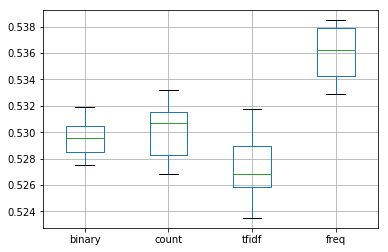

In [21]:
from matplotlib import pyplot
# summarise results
print(results.describe())
# plot results
results.boxplot()
pyplot.show()